# DLHub

DLHub is a self-service platform for publishing, applying, and creating ML/DL models. It provides:

1. publication capabilities to make models more discoverable, citable, and reusable;
2. the ability to easily run or test existing models; and
3. links to the data and computing infrastructure to re-train models for new applications.

DLHub benefits users in many ways. Data scientists can publish models (i.e., architectures and weights) and methods. Other scientists can apply existing models to new data with ease (e.g., by querying a prediction API for a deployed mode) and create new models with state-of-the-art techniques. Together, these capabilities lower barriers to employing ML/DL, making it easier for researchers to benefit from advances in ML/DL technologies.

## This notebook
This notebook showcases two DLHub use cases: the use of the OQMD pipeline and the use of a BNL model. The OQMD pipeline extracts data about crystalline materials from the Materials Data Facility before passing it through three servables on DLHub to predict their stability. The BNL model uses Globus Auth to pull x-ray images from Petrel - a multi-petabyte store at ANL - and quickly generate tags about what they are.

## OQMD


Predict the formation enthalpy (a measure of energetic stability) of several crystalline compounds using a machine learning model based on method by [Ward et al.](https://www.nature.com/articles/npjcompumats201628) and data from the OQMD. Here, we show all three steps of running the model - parsing a string to a [pymatgen](http://pymatgen.org/) object, using [matminer](https://hackingmaterials.github.io/matminer/) to compute features, and running a [scikit-learn](http://scikit-learn.org/stable/) model - as independent steps, but you can also execute the entire pipeline as a single call.

* Add Diagram
  * LW: Need anything from me?
* We might want to show the complete call, because it will look much easier


In [1]:
import os
import sys
import json
import requests
import matplotlib
import globus_sdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

## MDF and DLHub imports
from mdf_forge.forge import Forge
import mdf_toolbox
from dlhub_client import *

In [2]:
mdf = Forge()
dl = DLHub()
creds = mdf_toolbox.login(app_name="DLHub", services=["petrel", "data_mdf"])

### Get data from MDF

Gather the composition of a few Al-Cu compounds for which we will predict the formation enthalpy.

In [3]:
results = mdf.search_by_elements(elements=["Al","Cu"], 
                                 source_names=["oqmd"], 
                                 limit=10)
compositions = []
for res in results:
    compositions.append({"composition": res['material']['composition']})
df = pd.DataFrame(compositions)
df.head()

,composition
0,Al2Cu1
1,Al2Cu1
2,Al1Cu1
3,Al1Cu4
4,Al1Cu4


Our dataframe now contains the composition of our materials

### Query DLHub to Find the Model Steps
The `get_servables` command returns a list of all of the servables available in DLHub. Each servable is identified by a human-friendly name and human-unfriendly UUID that is required by the service, but we provide operations so that you don't need to remember it.

In [4]:
df_serv = dl.get_servables()
print('DLHub has {} servables!'.format(len(df_serv)))

DLHub has 6 servables!


Out of these, we can easily find the first step in our pipeline: the parser conversion

In [5]:
df_serv[['uuid', 'name']]

,uuid,name
0,1117ac20-3f54-11e8-b467-0ed5f89f718b,oqmd_model
1,9ff7a98c-3f54-11e8-b467-0ed5f89f718b,matminer_featurize
2,e127fb16-5852-11e8-9c2d-fa7ae01bbebc,resnet
3,d5a1653c-3ec5-4947-8c5a-28f6554ec339,matminer_util
4,9553d6a2-6a8d-4cda-8b81-7f38efab67e7,formation_energy
5,8c78939e-6422-4627-80ea-03ed8bfdf6ea,bmg


In [6]:
servable_name = "matminer_util"
servable_id = dl.get_id_by_name(servable_name)
print('Our first step is ID:', servable_id)

Our first step is ID: d5a1653c-3ec5-4947-8c5a-28f6554ec339


### Convert the Compositions to Pymatgen Objects
The first step in running the formation enthalpy model is to take a string, and parse it to a pymatgen Composition object that works with our next step in the toolchain. We seperate this part from the later steps in the pipeline so that other tools could reuse the Composition parser, and we can do some clever pipelining to make the models faster. Normally, you don't need to know this part exists. 

In [7]:
comps = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"composition":row['composition']}]}
    res = dl.infer(servable_id, data)
    comps.append(res['composition_object'][0])
df['composition_object'] = comps
df.head(2)

,composition,composition_object
0,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
1,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...


DLHub uses JSON to communicate between processes. As Python objects are not normally JSON-serializable, we first convert it to a `base64` string representation before sending it back to you. You can pretend this does not exist.

### Use Matminer to Compute Features
The key step of building a machine learning models of materials data is to compute informative inputs. For the composition of a material, these are things like the average radius of each of the atoms. We compute 145 of such features using matminer.

In [8]:
servable_name = "matminer_featurize"
servable_id = dl.get_id_by_name(servable_name)
features = [] 

for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"composition_object":row['composition_object']}]}
    res = dl.infer(servable_id, data)
    features.append(res['features'][0])

df['features'] = features
df.head()

,composition,composition_object,features
0,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."
1,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."
2,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0..."
3,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
4,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."


Note that the array now contains a column `features` where each entry is a list of different features that describe a material

## Run the Machine Learning Model
The last step is to invoke a scikit-learn model that takes the features to compute a formation enthalpy. 

In [9]:
servable_name = "oqmd_model"
servable_id = dl.get_id_by_name(servable_name)
preds = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"features":row['features']}]}
    res = dl.infer(servable_id, data)
    preds.append(res['prediction'][0])
df['prediction'] = preds
df.head()

,composition,composition_object,features,prediction
0,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089
1,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089
2,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0...",-0.179726
3,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
4,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846


Great! Now we've predicted the stability for all of the materials in our list

## Visualize the result
Just print out our materials with the lowest formation enthalpy, and make a histogram to see the distribution of energies

In [10]:
df.sort_values('prediction', ascending=True).head(3)

,composition,composition_object,features,prediction
5,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192
7,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192
0,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089


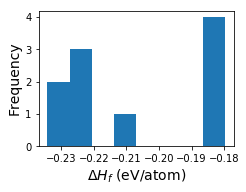

In [11]:
fig, ax = plt.subplots()

ax.hist(df['prediction'], bins=8)

ax.set_xlabel('$\Delta H_f$ (eV/atom)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

fig.set_size_inches(3.5, 2.5)

At this point, we've run a prediction of the stability of a few materials without ever having to install any software on our computer.

# BNL model

Use Globus Auth to get a token to pull data from Petrel then pass it through the BNL model.

*** Add Diagram

## Get a list of data from Petrel

In [12]:
# TODO -- put an ls here

## Generate a list of data to invoke against the model
Here we pull data from ...

Each image looks like this [example image]

In [13]:
file_start = "https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/Yager/model/raw/01470b9d_varied_sm/0000000"
file_end = ".mat"

data = []
for i in range(5, 7):
    filename = file_start + str(i) + file_end
    data.append({"file": filename, "token": creds['petrel'].access_token})
df_bnl = pd.DataFrame(data)
df_bnl.head()

,file,token
0,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,AgbgkWaMWKEO96m2o89q39MxYrq30EeoQJwq34wjKzNrWK...
1,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,AgbgkWaMWKEO96m2o89q39MxYrq30EeoQJwq34wjKzNrWK...


## Invoke the BNL model
In another example, we use DLHub to employ a deep learning model that uses residual deep learning networks to assign useful tags to SAX images...

#### This can be a bit slow if the result isn't cached. We are working to optimize.

In [ ]:
servable_name = "resnet"
servable_id = dl.get_id_by_name(servable_name)

preds=[]

for d in tqdm(data, total=len(data)):
    data = {"data":[d]}
    res = dl.infer(servable_id, data)
    preds.append(res[0][0])
df_bnl['prediction'] = preds
df_bnl.head()

In [ ]:
df_bnl['file'][0]

## Translate predictions into tags
To make these predictions useful to humans...

In [ ]:
df_tags = pd.read_csv('./tags.txt',  '\n', header=None) ## Eventually this will be read in from the model metadata in Search

def get_tags(entry):
    df_tmp = pd.DataFrame()
    df_tmp['probability'] = entry['prediction']
    df_tmp['tags'] = df_tags[0]
    return df_tmp


df_p = get_tags(df_bnl.iloc[0])
df_p.sort_values(["probability"], ascending=False).head(10)

Our machine learning model predicts a 99.9% certainity that the beam is off image. We plan to incorporate this kind of model into the beamline facilities at ANL so that scientists (or robots!) at the beamline can quickly identify when their experiments are producing useless data.

# Metallic Glass Discovery

## In Progress -- This example doesn't work yet

In [ ]:
servable_name = "bmg"
servable_id = dl.get_id_by_name(servable_name)

data = {"data":['Zr', 'Cr', 'Fe']}

lst_res = dl.infer(servable_id, data)
# print (lst_res)
# util_path = '{service}/servables/{servable_id}/run'.format(service=dlhub_service,
#                                                               servable_id=servable_id)
# r = requests.post(util_path, json=payload)
# lst_res = json.loads(r.text)

In [ ]:
lst_res

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matminer.featurizers.composition import ElementFraction
from pymatgen import Composition
import pickle as pkl
import numpy as np
import ternary
import gzip


def ternary_from_data(data, elems=["Left", "Center", "Right"], scale=32):
    _, ax = plt.subplots()
    
    # Make the plot 
    fig, tax = ternary.figure(scale=scale, ax=ax)
    tax.gridlines(color="black", multiple=10)
    tax.boundary(linewidth=1)

    # Generate the heatmap
    sc = heatmap(data, scale, cmap=make_cmap(), ax=ax, vmin=0.5, vmax=1, colorbar=True)
    
    # Make it prettier
    plt.axis('off')
    ax.text(1.05 * scale, -0.05 * scale, elems[0], ha='right', fontsize=12) # 1st elem
    ax.text(.50 * scale, .90 * scale, elems[1], ha='center', fontsize=12) # 2nd elem
    ax.text(-.05 * scale, -.05 * scale, elems[2], ha='left', fontsize=12) # 3rd elem
    
def make_cmap(base='viridis_r', scale_factor=1.5, cutoff=0.9, adjust_factor=0.1):
    """Make a colormap that this scaled to emphasize the top of the range.
    
    Two kinds of emphasis:
        1) Scaling the colormap to have a stronger gradient at the top
        2) Making the colors below a treshold lighter
        
    Inputs:
        base - str, base color map name
        scale_factor - float, how much to exaggerate the range at the top (larger value -> larger scaling)
        cutoff - float, treshold below which to lighten colors (0-1)
        adjust_factor - float, how much to dampen colors (0-1)
    Returns:
        Colormap
    """
    
    # Get the base colormap
    v = cm.get_cmap('viridis_r')
    
    # Scale it
    new_list = v(np.linspace(0,1,300) ** scale_factor)

    # Apply cutoff
    new_list[:int(len(new_list)*cutoff),:3] += (1 - new_list[:int(len(new_list)*cutoff),:3]) * adjust_factor
    return ListedColormap(new_list, name='%s_scaled'%base)


In [ ]:
ternary_from_data(lst_res)

In [ ]:
servable_name = "bmg"
servable_id = dl.get_id_by_name(servable_name)

data = {"data":['Zr', 'Cr', 'Fe']}
res = dl.infer(servable_id, data)


In [ ]:
df_tags